# Lesson 2. First-order Ordinary Differential Equations II
## Companion Notebook — Examples & Exercises

**Topics covered:**
1. Well-Posed Problems & Continuous Dependence on Initial Data
2. Euler's Explicit (Forward) Method
3. Euler's Implicit (Backward) Method
4. Direction Fields
5. Taylor Series Method
6. Picard Iteration
7. Comparison of All Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

---
## 1. Well-Posed Problems: Continuous Dependence on Initial Data

**Theorem:** If $f(x,y)$ satisfies a Lipschitz condition in $y$, then
$$|y(x) - z(x)| \leq |\delta| \, e^{L|x - x_0|}$$
where $y$ and $z$ solve the same ODE with initial conditions $y_0$ and $y_0 + \delta$.

### Example: $y' = 5xy$, comparing $y(0)=1$ vs $y(0)=1.0002$

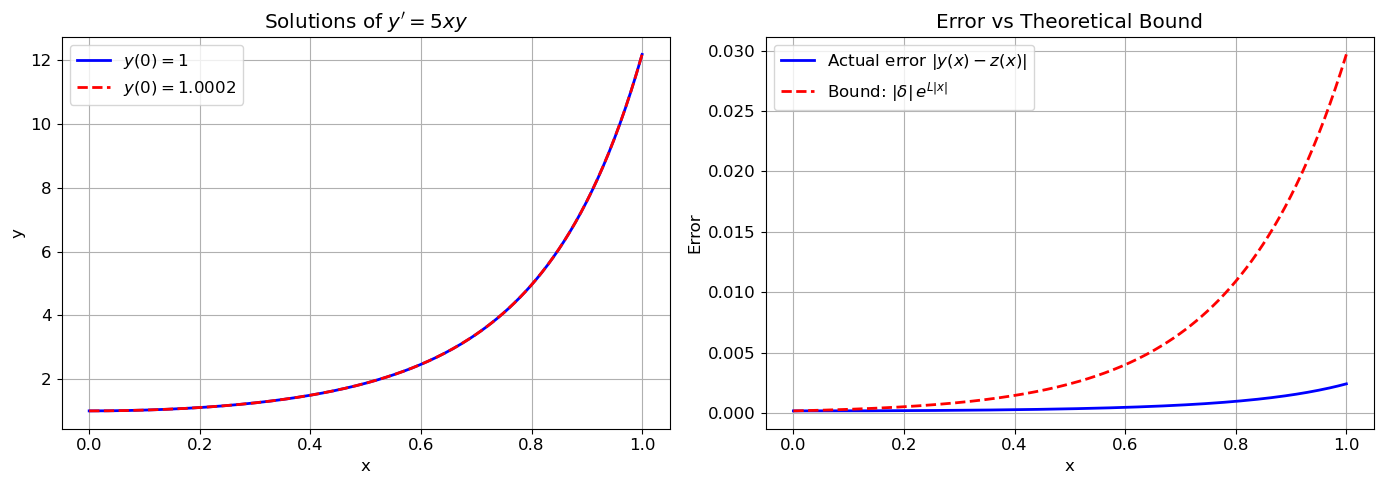

y(1) with y(0)=1:      12.1825
z(1) with y(0)=1.0002: 12.1849
Difference at x=1:     0.0024


In [2]:
# Exact solution: y(x) = C * exp(5/2 * x^2)
x = np.linspace(0, 1, 200)

y_exact = np.exp(2.5 * x**2)            # y(0) = 1
z_exact = 1.0002 * np.exp(2.5 * x**2)   # y(0) = 1.0002

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot solutions
axes[0].plot(x, y_exact, 'b-', linewidth=2, label=r'$y(0) = 1$')
axes[0].plot(x, z_exact, 'r--', linewidth=2, label=r'$y(0) = 1.0002$')
axes[0].set_xlabel('x'); axes[0].set_ylabel('y')
axes[0].set_title(r"Solutions of $y' = 5xy$")
axes[0].legend(); axes[0].grid(True)

# Plot error vs bound
delta = 0.0002
actual_error = np.abs(y_exact - z_exact)
# Lipschitz constant for f(x,y)=5xy on [0,1]: |df/dy| = 5|x| <= 5, so L=5
L = 5.0
error_bound = np.abs(delta) * np.exp(L * np.abs(x))

axes[1].plot(x, actual_error, 'b-', linewidth=2, label='Actual error $|y(x)-z(x)|$')
axes[1].plot(x, error_bound, 'r--', linewidth=2, label=r'Bound: $|\delta|\,e^{L|x|}$')
axes[1].set_xlabel('x'); axes[1].set_ylabel('Error')
axes[1].set_title('Error vs Theoretical Bound')
axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"y(1) with y(0)=1:      {np.exp(2.5):.4f}")
print(f"z(1) with y(0)=1.0002: {1.0002*np.exp(2.5):.4f}")
print(f"Difference at x=1:     {0.0002*np.exp(2.5):.4f}")

---
## 2. Euler's Explicit (Forward) Method

**Formula:** $y_{i+1} = y_i + h \cdot f(x_i, y_i)$

### Implementation

In [3]:
def euler_explicit(f, x0, y0, xend, N):
    """Forward Euler method.
    Returns arrays of x-values and y-values."""
    h = (xend - x0) / N
    xs = np.zeros(N + 1)
    ys = np.zeros(N + 1)
    xs[0], ys[0] = x0, y0
    for i in range(N):
        ys[i+1] = ys[i] + h * f(xs[i], ys[i])
        xs[i+1] = xs[i] + h
    return xs, ys

### Example 1: $y' = 5xy$, $y(0) = 1$, $0 \le x \le 1$, $N=5$

In [4]:
f1 = lambda x, y: 5 * x * y
xs1, ys1 = euler_explicit(f1, 0, 1, 1, 5)

# Print table
print(f"{'i':>3} {'x_i':>8} {'y_i':>12} {'y_{i+1}':>12}")
print("-" * 40)
for i in range(5):
    h = 0.2
    y_next = ys1[i] + h * f1(xs1[i], ys1[i])
    print(f"{i:>3} {xs1[i]:>8.1f} {ys1[i]:>12.4f} {y_next:>12.4f}")
print(f"\nApproximate value: y(1) ≈ {ys1[-1]:.4f}")
print(f"Exact value:       y(1) = exp(5/2) ≈ {np.exp(2.5):.4f}")

  i      x_i          y_i      y_{i+1}
----------------------------------------
  0      0.0       1.0000       1.0000
  1      0.2       1.0000       1.2000
  2      0.4       1.2000       1.6800
  3      0.6       1.6800       2.6880
  4      0.8       2.6880       4.8384

Approximate value: y(1) ≈ 4.8384
Exact value:       y(1) = exp(5/2) ≈ 12.1825


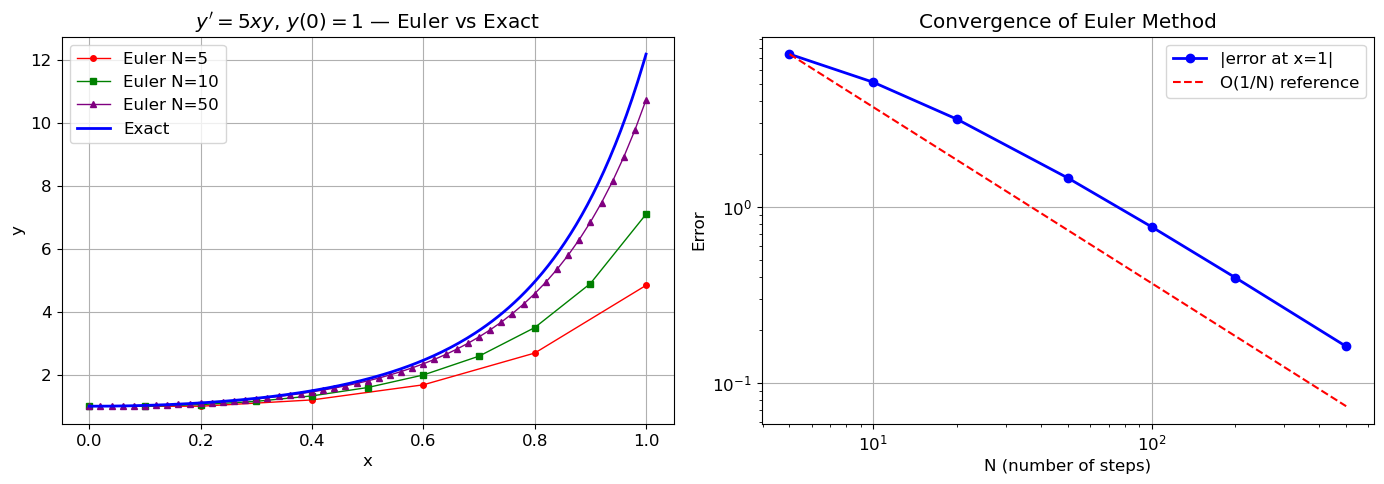

In [5]:
# Plot: Euler vs Exact for y' = 5xy
x_fine = np.linspace(0, 1, 200)
y_exact1 = np.exp(2.5 * x_fine**2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for N, color, marker in [(5, 'red', 'o'), (10, 'green', 's'), (50, 'purple', '^')]:
    xs_e, ys_e = euler_explicit(f1, 0, 1, 1, N)
    axes[0].plot(xs_e, ys_e, color=color, marker=marker, markersize=4,
                 label=f'Euler N={N}', linewidth=1)

axes[0].plot(x_fine, y_exact1, 'b-', linewidth=2, label='Exact')
axes[0].set_xlabel('x'); axes[0].set_ylabel('y')
axes[0].set_title(r"$y' = 5xy$, $y(0)=1$ — Euler vs Exact")
axes[0].legend(); axes[0].grid(True)

# Convergence study
Ns = [5, 10, 20, 50, 100, 200, 500]
errors = []
for N in Ns:
    _, ys_e = euler_explicit(f1, 0, 1, 1, N)
    errors.append(abs(ys_e[-1] - np.exp(2.5)))

axes[1].loglog(Ns, errors, 'bo-', linewidth=2, label='|error at x=1|')
axes[1].loglog(Ns, [errors[0]*Ns[0]/N for N in Ns], 'r--', label='O(1/N) reference')
axes[1].set_xlabel('N (number of steps)'); axes[1].set_ylabel('Error')
axes[1].set_title('Convergence of Euler Method')
axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()

### Example 2: $y' = x^2 y + 1$, $y(0) = 1$, $0 \le x \le 1$, $N=10$

In [6]:
f2 = lambda x, y: x**2 * y + 1
xs2, ys2 = euler_explicit(f2, 0, 1, 1, 10)

print(f"{'i':>3} {'x_i':>8} {'y_i':>12}")
print("-" * 28)
for i in range(11):
    print(f"{i:>3} {xs2[i]:>8.1f} {ys2[i]:>12.6f}")

# Compare with scipy
sol2 = solve_ivp(lambda x, y: f2(x, y[0]), [0, 1], [1], dense_output=True, rtol=1e-12)
y_ref = sol2.sol(1)[0]
print(f"\nEuler y(1)   ≈ {ys2[-1]:.6f}")
print(f"scipy y(1)   ≈ {y_ref:.6f}")

  i      x_i          y_i
----------------------------
  0      0.0     1.000000
  1      0.1     1.100000
  2      0.2     1.201100
  3      0.3     1.305904
  4      0.4     1.417658
  5      0.5     1.540340
  6      0.6     1.678849
  7      0.7     1.839287
  8      0.8     2.029412
  9      0.9     2.259295
 10      1.0     2.542297

Euler y(1)   ≈ 2.542297
scipy y(1)   ≈ 2.685191


### Example 3: $y' = 1 + x\sin(xy)$, $y(0) = 0$, $0 \le x \le 2$, $N=5$

  i      x_i          y_i   f(x_i,y_i)      y_{i+1}
----------------------------------------------------
  0      0.0       0.0000       1.0000       0.4000
  1      0.4       0.4000       1.0637       0.8255
  2      0.8       0.8255       1.4907       1.4218
  3      1.2       1.4218       2.1890       2.2974
  4      1.6       2.2974       0.1853       2.3715

Approximate value: y(2) ≈ 2.3715


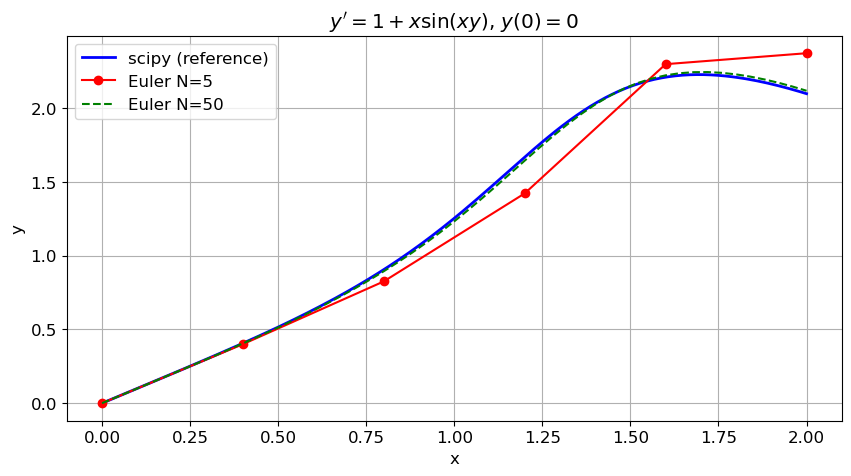

In [7]:
f3 = lambda x, y: 1 + x * np.sin(x * y)
xs3, ys3 = euler_explicit(f3, 0, 0, 2, 5)

print(f"{'i':>3} {'x_i':>8} {'y_i':>12} {'f(x_i,y_i)':>12} {'y_{i+1}':>12}")
print("-" * 52)
for i in range(5):
    fi = f3(xs3[i], ys3[i])
    print(f"{i:>3} {xs3[i]:>8.1f} {ys3[i]:>12.4f} {fi:>12.4f} {ys3[i+1]:>12.4f}")

print(f"\nApproximate value: y(2) ≈ {ys3[-1]:.4f}")

# Compare with scipy
sol3 = solve_ivp(lambda x, y: [f3(x, y[0])], [0, 2], [0], dense_output=True, rtol=1e-12)
x_plot = np.linspace(0, 2, 200)

plt.figure(figsize=(10, 5))
plt.plot(x_plot, sol3.sol(x_plot)[0], 'b-', linewidth=2, label='scipy (reference)')
plt.plot(xs3, ys3, 'ro-', linewidth=1.5, markersize=6, label='Euler N=5')
xs3_50, ys3_50 = euler_explicit(f3, 0, 0, 2, 50)
plt.plot(xs3_50, ys3_50, 'g--', linewidth=1.5, label='Euler N=50')
plt.xlabel('x'); plt.ylabel('y')
plt.title(r"$y' = 1 + x\sin(xy)$, $y(0)=0$")
plt.legend(); plt.grid(True)
plt.show()

---
## 3. Euler's Implicit (Backward) Method

**Formula:** $y_{i+1} = y_i + h \cdot f(x_{i+1}, y_{i+1})$

For the linear case $f(x,y) = xy + 1$, we can solve algebraically for $y_{i+1}$.

### Example 4: $y' = xy + 1$, $y(0)=1$, $h=0.25$

Implicit Euler Method: y' = xy + 1, y(0)=1, h=0.25
  n      x_n          y_n
----------------------------
  0     0.00       1.0000
  1     0.25       1.3333
  2     0.50       1.8095
  3     0.75       2.5348
  4     1.00       3.7131


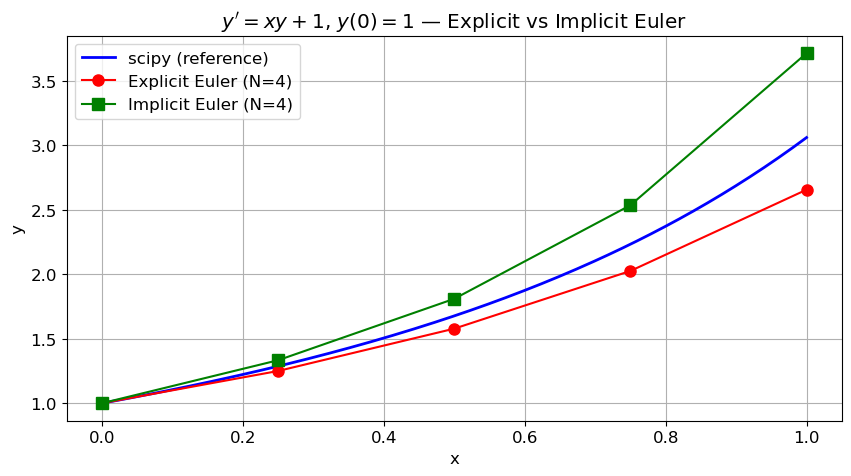


At x=1: Explicit=2.6552, Implicit=3.7131, Reference=3.0594


In [8]:
def euler_implicit_linear(x0, y0, xend, N):
    """Backward Euler for y' = xy + 1.
    At each step: y_{i+1} = y_i + h*(x_{i+1}*y_{i+1} + 1)
    => y_{i+1}(1 - h*x_{i+1}) = y_i + h
    => y_{i+1} = (y_i + h) / (1 - h*x_{i+1})"""
    h = (xend - x0) / N
    xs = np.zeros(N + 1)
    ys = np.zeros(N + 1)
    xs[0], ys[0] = x0, y0
    for i in range(N):
        xs[i+1] = xs[i] + h
        ys[i+1] = (ys[i] + h) / (1 - h * xs[i+1])
    return xs, ys

xs4, ys4 = euler_implicit_linear(0, 1, 1, 4)

print("Implicit Euler Method: y' = xy + 1, y(0)=1, h=0.25")
print(f"{'n':>3} {'x_n':>8} {'y_n':>12}")
print("-" * 28)
for i in range(5):
    print(f"{i:>3} {xs4[i]:>8.2f} {ys4[i]:>12.4f}")

# Compare explicit vs implicit vs scipy
f4 = lambda x, y: x * y + 1
xs4e, ys4e = euler_explicit(f4, 0, 1, 1, 4)
sol4 = solve_ivp(lambda x, y: [f4(x, y[0])], [0, 1], [1], dense_output=True, rtol=1e-12)
x_plot = np.linspace(0, 1, 200)

plt.figure(figsize=(10, 5))
plt.plot(x_plot, sol4.sol(x_plot)[0], 'b-', linewidth=2, label='scipy (reference)')
plt.plot(xs4e, ys4e, 'ro-', linewidth=1.5, markersize=8, label='Explicit Euler (N=4)')
plt.plot(xs4, ys4, 'gs-', linewidth=1.5, markersize=8, label='Implicit Euler (N=4)')
plt.xlabel('x'); plt.ylabel('y')
plt.title(r"$y' = xy + 1$, $y(0)=1$ — Explicit vs Implicit Euler")
plt.legend(); plt.grid(True)
plt.show()

print(f"\nAt x=1: Explicit={ys4e[-1]:.4f}, Implicit={ys4[-1]:.4f}, Reference={sol4.sol(1)[0]:.4f}")

---
## 4. Direction Fields

The direction field plots short arrows at grid points $(x,y)$ with slope $f(x,y)$.
This gives a qualitative picture of all solution curves.

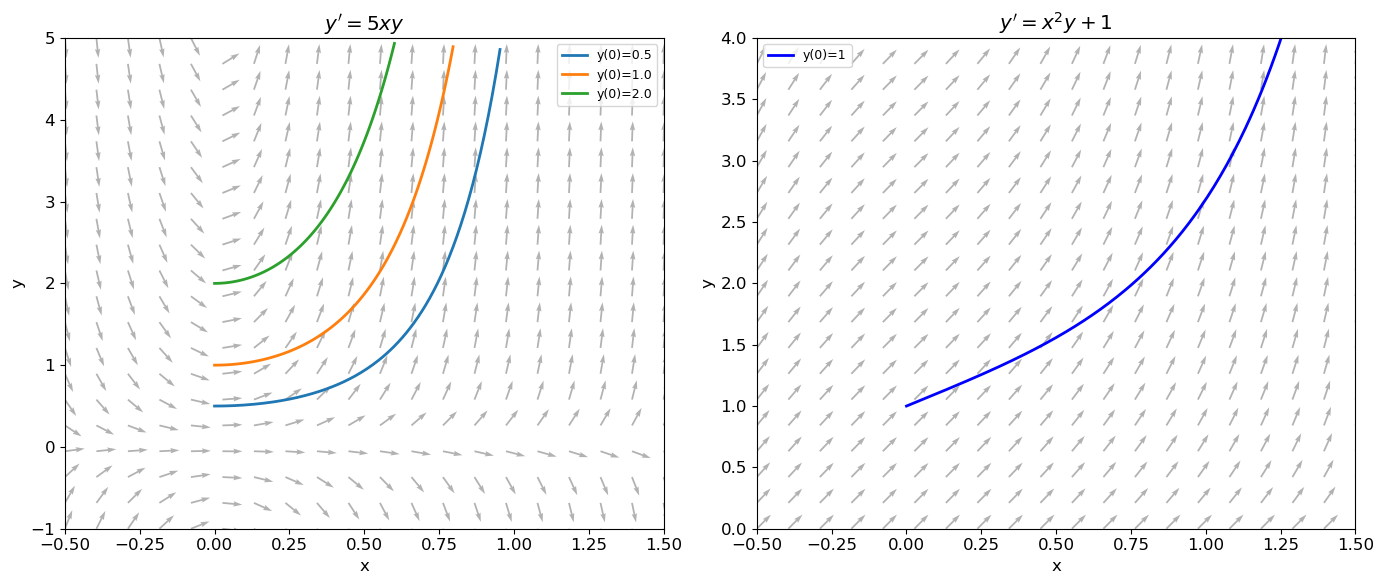

In [9]:
def plot_direction_field(f, xrange, yrange, title, ax, nx=20, ny=20):
    """Plot a direction field for y' = f(x,y)."""
    x = np.linspace(*xrange, nx)
    y = np.linspace(*yrange, ny)
    X, Y = np.meshgrid(x, y)
    U = np.ones_like(X)
    V = f(X, Y)
    # Normalize arrows
    N = np.sqrt(U**2 + V**2)
    N = np.where(N == 0, 1, N)
    U, V = U / N, V / N
    ax.quiver(X, Y, U, V, color='gray', alpha=0.6, scale=30)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title(title)
    ax.set_xlim(xrange); ax.set_ylim(yrange)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Direction field for y' = 5xy
plot_direction_field(lambda x, y: 5*x*y, (-0.5, 1.5), (-1, 5),
                     r"$y' = 5xy$", axes[0])
# Add a few solution curves
for y0 in [0.5, 1.0, 2.0]:
    x_c = np.linspace(0, 1.3, 200)
    y_c = y0 * np.exp(2.5 * x_c**2)
    mask = y_c < 5
    axes[0].plot(x_c[mask], y_c[mask], linewidth=2, label=f'y(0)={y0}')
axes[0].legend(fontsize=9)

# Direction field for y' = x^2*y + 1
plot_direction_field(lambda x, y: x**2*y + 1, (-0.5, 1.5), (0, 4),
                     r"$y' = x^2 y + 1$", axes[1])
sol_df = solve_ivp(lambda x, y: [x**2*y[0]+1], [0, 1.5], [1], dense_output=True, rtol=1e-12)
x_df = np.linspace(0, 1.4, 200)
axes[1].plot(x_df, sol_df.sol(x_df)[0], 'b-', linewidth=2, label='y(0)=1')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

---
## 5. Taylor Series Method

We compute higher derivatives symbolically and build a Taylor polynomial approximation.

### Example 1: $y' = 5xy$, $y(0) = 1$

Derivatives at x=0:
  y(0)    = 1
  y'(0)   = 0
  y''(0)  = 5
  y'''(0) = 0
  y''''(0)= 75


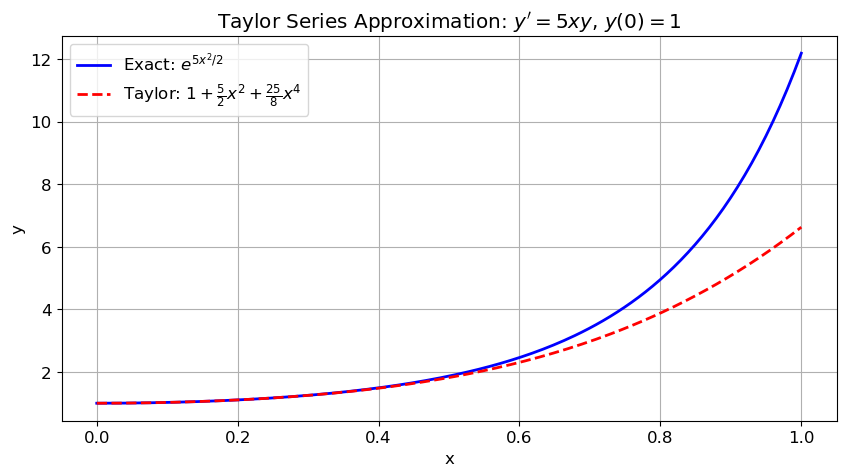


Taylor approximation at x=1: 6.6250
Exact value at x=1:          12.1825


In [10]:
x_sym = sp.Symbol('x')
y_sym = sp.Function('y')

# y' = 5xy
f_expr = 5 * x_sym * y_sym(x_sym)

# Compute derivatives at x=0
# y(0)=1, y'=5xy, y''=5y+5xy', y'''=10y'+5xy'', y''''=15y''+5xy'''
y0_val = 1
yp0 = 5 * 0 * y0_val  # y'(0) = 0
ypp0 = 5 * y0_val + 5 * 0 * yp0  # y''(0) = 5
yppp0 = 10 * yp0 + 5 * 0 * ypp0  # y'''(0) = 0
y4_0 = 15 * ypp0 + 5 * 0 * yppp0  # y''''(0) = 75

print("Derivatives at x=0:")
print(f"  y(0)    = {y0_val}")
print(f"  y'(0)   = {yp0}")
print(f"  y''(0)  = {ypp0}")
print(f"  y'''(0) = {yppp0}")
print(f"  y''''(0)= {y4_0}")

# Taylor polynomial
x_vals = np.linspace(0, 1, 200)
taylor1 = (y0_val + yp0*x_vals + ypp0/2*x_vals**2 +
           yppp0/6*x_vals**3 + y4_0/24*x_vals**4)
exact1 = np.exp(2.5 * x_vals**2)

plt.figure(figsize=(10, 5))
plt.plot(x_vals, exact1, 'b-', linewidth=2, label='Exact: $e^{5x^2/2}$')
plt.plot(x_vals, taylor1, 'r--', linewidth=2,
         label=r'Taylor: $1 + \frac{5}{2}x^2 + \frac{25}{8}x^4$')
plt.xlabel('x'); plt.ylabel('y')
plt.title(r"Taylor Series Approximation: $y' = 5xy$, $y(0)=1$")
plt.legend(); plt.grid(True)
plt.show()

print(f"\nTaylor approximation at x=1: {taylor1[-1]:.4f}")
print(f"Exact value at x=1:          {np.exp(2.5):.4f}")

### Example 2: $y' = x^2 y + 1$, $y(0) = 1$

Derivatives at x=0 for y' = x²y + 1:
  y(0)    = 1
  y'(0)   = 1
  y''(0)  = 0
  y'''(0) = 2
  y''''(0)= 6


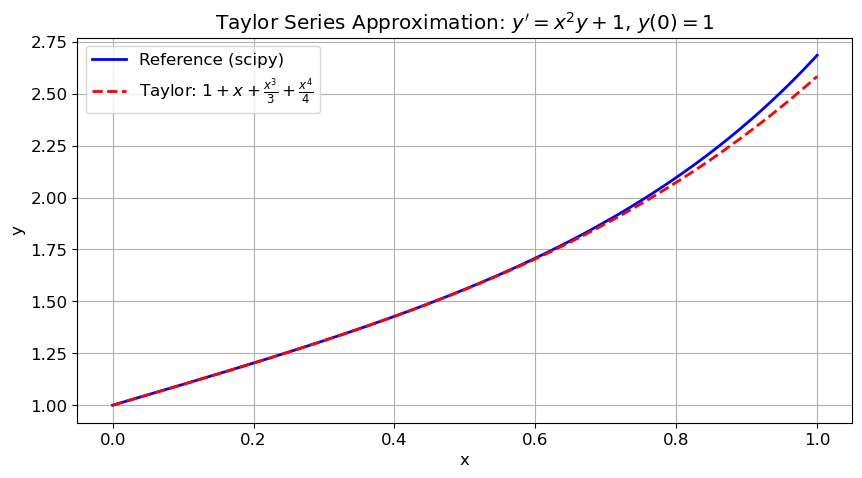


Taylor approximation at x=1: 2.5833
Reference value at x=1:      2.6852


In [11]:
# y' = x^2*y + 1
# y(0)=1, y'(0)=1, y''(0)=0, y'''(0)=2, y''''(0)=6
y0 = 1; yp = 1; ypp = 0; yppp = 2; y4 = 6

print("Derivatives at x=0 for y' = x²y + 1:")
print(f"  y(0)    = {y0}")
print(f"  y'(0)   = {yp}")
print(f"  y''(0)  = {ypp}")
print(f"  y'''(0) = {yppp}")
print(f"  y''''(0)= {y4}")

x_vals = np.linspace(0, 1, 200)
taylor2 = y0 + yp*x_vals + ypp/2*x_vals**2 + yppp/6*x_vals**3 + y4/24*x_vals**4

sol_t2 = solve_ivp(lambda x, y: [x**2*y[0]+1], [0, 1], [1], dense_output=True, rtol=1e-12)
ref2 = sol_t2.sol(x_vals)[0]

plt.figure(figsize=(10, 5))
plt.plot(x_vals, ref2, 'b-', linewidth=2, label='Reference (scipy)')
plt.plot(x_vals, taylor2, 'r--', linewidth=2,
         label=r'Taylor: $1 + x + \frac{x^3}{3} + \frac{x^4}{4}$')
plt.xlabel('x'); plt.ylabel('y')
plt.title(r"Taylor Series Approximation: $y' = x^2 y + 1$, $y(0)=1$")
plt.legend(); plt.grid(True)
plt.show()

print(f"\nTaylor approximation at x=1: {taylor2[-1]:.4f}")
print(f"Reference value at x=1:      {sol_t2.sol(1)[0]:.4f}")

---
## 6. Picard Iteration

**Formula:** $y_{n+1}(x) = y_0 + \int_0^x f(s, y_n(s))\,ds$

### Example 1: $y' = 5xy$, $y(0) = 1$ (symbolic)

In [12]:
x_s = sp.Symbol('x')
s = sp.Symbol('s')

# Picard iteration for y' = 5xy, y(0) = 1
y_picard = [sp.Integer(1)]  # y_0(x) = 1

print("Picard iterations for y' = 5xy, y(0)=1:")
print(f"  y_0(x) = {y_picard[0]}")

for n in range(4):
    integrand = 5 * s * y_picard[-1].subs(x_s, s)
    y_next = 1 + sp.integrate(integrand, (s, 0, x_s))
    y_next = sp.expand(y_next)
    y_picard.append(y_next)
    print(f"  y_{n+1}(x) = {y_next}")

# Evaluate at x=1
print(f"\ny_4(1) = {float(y_picard[4].subs(x_s, 1)):.4f}")
print(f"Exact:   {float(sp.exp(sp.Rational(5,2))):.4f}")

Picard iterations for y' = 5xy, y(0)=1:
  y_0(x) = 1
  y_1(x) = 5*x**2/2 + 1
  y_2(x) = 25*x**4/8 + 5*x**2/2 + 1
  y_3(x) = 125*x**6/48 + 25*x**4/8 + 5*x**2/2 + 1
  y_4(x) = 625*x**8/384 + 125*x**6/48 + 25*x**4/8 + 5*x**2/2 + 1

y_4(1) = 10.8568
Exact:   12.1825


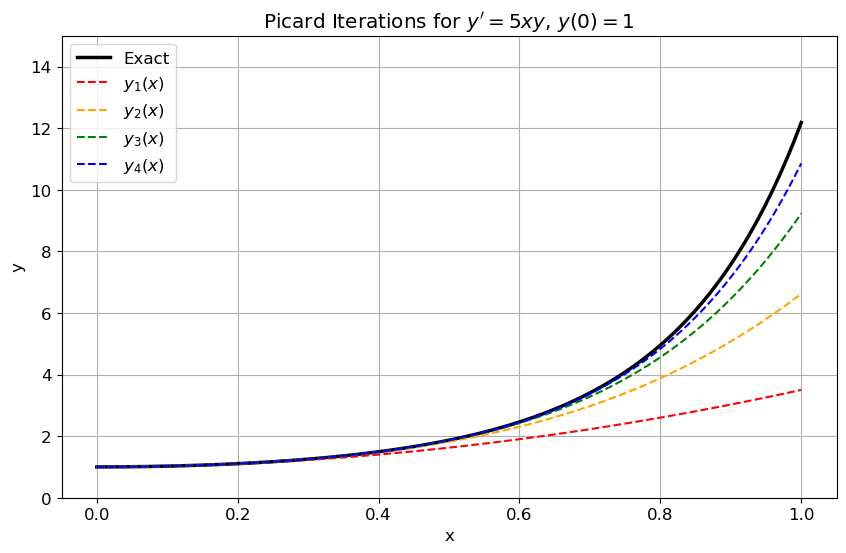

In [13]:
# Plot Picard iterations vs exact
x_plot = np.linspace(0, 1, 200)
exact_vals = np.exp(2.5 * x_plot**2)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, exact_vals, 'k-', linewidth=2.5, label='Exact')

colors = ['red', 'orange', 'green', 'blue']
for i in range(1, 5):
    y_func = sp.lambdify(x_s, y_picard[i], 'numpy')
    plt.plot(x_plot, y_func(x_plot), '--', color=colors[i-1],
             linewidth=1.5, label=f'$y_{i}(x)$')

plt.xlabel('x'); plt.ylabel('y')
plt.title(r"Picard Iterations for $y' = 5xy$, $y(0)=1$")
plt.legend(); plt.grid(True)
plt.ylim(0, 15)
plt.show()

### Example 2: $y' = x^2 y + 1$, $y(0) = 1$ (symbolic)

In [14]:
# Picard iteration for y' = x^2*y + 1, y(0) = 1
y_picard2 = [sp.Integer(1)]

print("Picard iterations for y' = x²y + 1, y(0)=1:")
print(f"  y_0(x) = {y_picard2[0]}")

for n in range(4):
    integrand = s**2 * y_picard2[-1].subs(x_s, s) + 1
    y_next = 1 + sp.integrate(integrand, (s, 0, x_s))
    y_next = sp.expand(y_next)
    y_picard2.append(y_next)
    print(f"  y_{n+1}(x) = {y_next}")

print(f"\ny_4(1) = {float(y_picard2[4].subs(x_s, 1)):.4f}")

Picard iterations for y' = x²y + 1, y(0)=1:
  y_0(x) = 1
  y_1(x) = x**3/3 + x + 1
  y_2(x) = x**6/18 + x**4/4 + x**3/3 + x + 1
  y_3(x) = x**9/162 + x**7/28 + x**6/18 + x**4/4 + x**3/3 + x + 1
  y_4(x) = x**12/1944 + x**10/280 + x**9/162 + x**7/28 + x**6/18 + x**4/4 + x**3/3 + x + 1

y_4(1) = 2.6849


---
## 7. Comparison of All Methods

### IVP 1: $y' = 5xy$, $y(0) = 1$, evaluate at $x = 1$

Method                       y(1)      |Error|
----------------------------------------------
Exact                     12.1825       0.0000
Euler (N=5)                4.8384       7.3441
Taylor (4th)               4.7308       7.4517
Picard (4th)              10.8568       1.3257


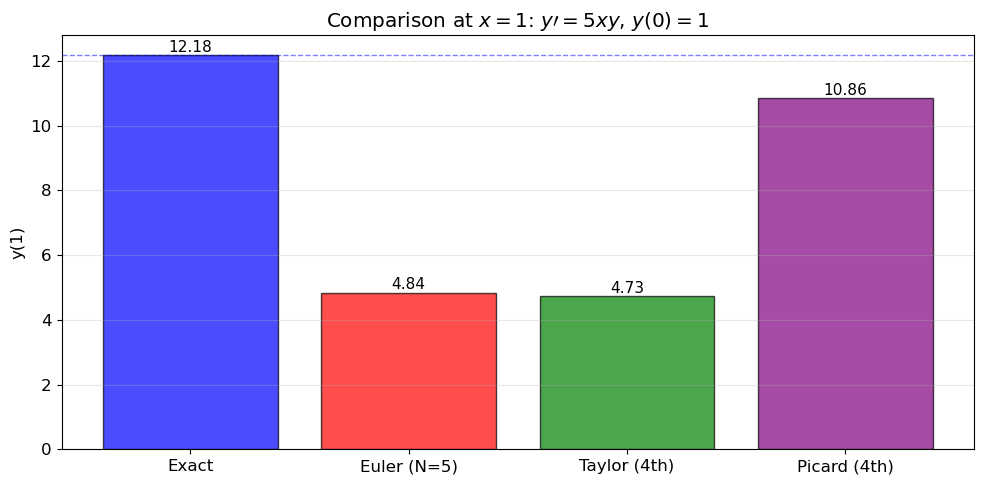

In [15]:
exact_val1 = np.exp(2.5)

# Euler N=5
_, ys_eu1 = euler_explicit(f1, 0, 1, 1, 5)
euler_val1 = ys_eu1[-1]

# Taylor 4th degree
taylor_val1 = 1 + 5/2 + 25/24 + 125/720 + 625/40320

# Picard 4th step
picard_val1 = 1 + 5/2 + 25/8 + 125/48 + 625/384

methods = ['Exact', 'Euler (N=5)', 'Taylor (4th)', 'Picard (4th)']
values = [exact_val1, euler_val1, taylor_val1, picard_val1]
errors = [0, abs(euler_val1 - exact_val1), abs(taylor_val1 - exact_val1),
          abs(picard_val1 - exact_val1)]

print(f"{'Method':<20} {'y(1)':>12} {'|Error|':>12}")
print("-" * 46)
for m, v, e in zip(methods, values, errors):
    print(f"{m:<20} {v:>12.4f} {e:>12.4f}")

# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'purple']
bars = ax.bar(methods, values, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=exact_val1, color='blue', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('y(1)')
ax.set_title(r"Comparison at $x=1$: $y\prime = 5xy$, $y(0)=1$")
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}', ha='center', fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### IVP 2: $y' = x^2 y + 1$, $y(0) = 1$, evaluate at $x = 1$

Method                       y(1)      |Error|
----------------------------------------------
Reference                  2.6852       0.0000
Euler (N=10)               2.5423       0.1429
Taylor (4th)               2.5833       0.1019
Picard (4th)               2.6849       0.0003


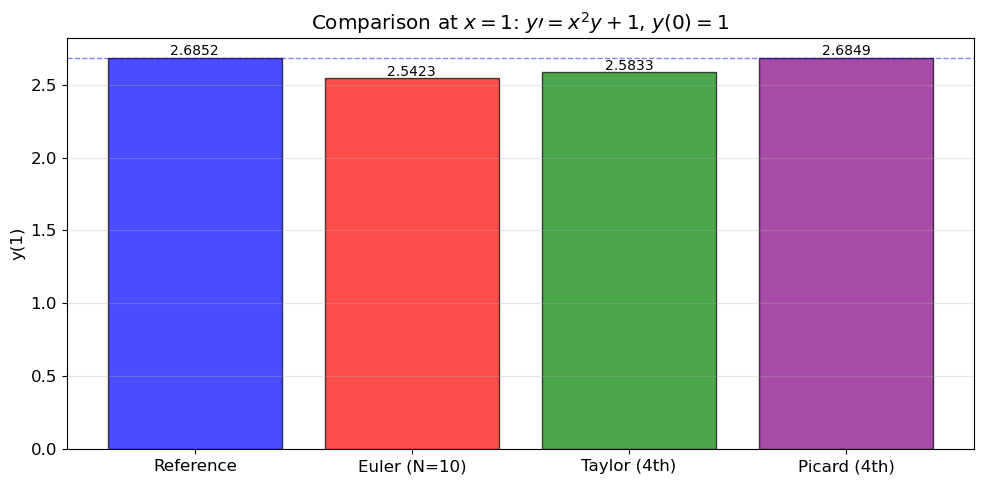

In [16]:
ref_val2 = float(sol_t2.sol(1)[0])

# Euler N=10
_, ys_eu2 = euler_explicit(f2, 0, 1, 1, 10)
euler_val2 = ys_eu2[-1]

# Taylor 4th degree
taylor_val2 = 1 + 1 + 1/3 + 1/4

# Picard 4th step
picard_val2 = float(y_picard2[4].subs(x_s, 1))

methods2 = ['Reference', 'Euler (N=10)', 'Taylor (4th)', 'Picard (4th)']
values2 = [ref_val2, euler_val2, taylor_val2, picard_val2]
errors2 = [0, abs(euler_val2 - ref_val2), abs(taylor_val2 - ref_val2),
           abs(picard_val2 - ref_val2)]

print(f"{'Method':<20} {'y(1)':>12} {'|Error|':>12}")
print("-" * 46)
for m, v, e in zip(methods2, values2, errors2):
    print(f"{m:<20} {v:>12.4f} {e:>12.4f}")

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'purple']
bars = ax.bar(methods2, values2, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=ref_val2, color='blue', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('y(1)')
ax.set_title(r"Comparison at $x=1$: $y\prime = x^2 y + 1$, $y(0)=1$")
for bar, val in zip(bars, values2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.4f}', ha='center', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 8. Exercises

Try these on your own!

**Exercise 1.** Apply the forward Euler method to $y' = 5xy$, $y(0)=1$ with $N=10, 20, 50, 100$ and plot the convergence of the error at $x=1$ as a function of $h$.

**Exercise 2.** Implement a general implicit Euler method using `scipy.optimize.fsolve` and apply it to $y' = -10y + 10\sin(x)$, $y(0)=1$ on $[0, 5]$. Compare with explicit Euler. Which method is more stable for large step sizes?

**Exercise 3.** Compute the 6th-order Taylor polynomial for $y' = x^2 y + 1$, $y(0)=1$ (you will need $y^{(5)}(0)$ and $y^{(6)}(0)$). How much does the approximation at $x=1$ improve?

**Exercise 4.** Plot the direction field for $y' = y - x^2 + 1$ on $[0, 4] \times [-1, 4]$ and overlay several solution curves with different initial conditions.

**Exercise 5.** Perform 5 Picard iterations for $y' = -2xy$, $y(0)=1$. The exact solution is $e^{-x^2}$. Plot each iteration and observe convergence.

In [17]:
# Space for your solutions
